In [1]:
import sys,os,scipy,netCDF4
#sys.path.append('/home/jovyan/.local/lib/python3.8/site-packages/nfdrs-0.1')
import nfdrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar, progress
from dask.distributed import wait, progress, Client, LocalCluster
from shapely.geometry import mapping

### To Do
Need to apply mask to calculations to avoid computations outside an AOI

In [2]:
diagnostics = False

In [3]:
cluster = LocalCluster(dashboard_address=':8788')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8788/status,
Dashboard: http://127.0.0.1:8788/status,Workers: 8
Total threads: 56,Total memory: 127.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52779,Workers: 8
Dashboard: http://127.0.0.1:8788/status,Total threads: 56
Started: Just now,Total memory: 127.91 GiB
Comm: tcp://127.0.0.1:52842,Total threads: 7
Dashboard: http://127.0.0.1:52845/status,Memory: 15.99 GiB
Nanny: tcp://127.0.0.1:52787,


In [4]:
bnd = gpd.read_file('zip://./Data/ne_10m_admin_1_states_provinces_lakes.zip')
bnd = bnd[bnd['gu_a3'] == 'USA']
bnd = bnd[(bnd['name'] != "Alaska")]
bnd = bnd[(bnd['name'] != "Hawaii")]

In [83]:
psabnd = gpd.read_file('./Data/National_PSA_Current.shp')

In [84]:
psabnd['GACCName'].unique()

array(['Southern Area Coordination Center',
       'Great Basin Coordination Center',
       'Northern California Geographic Area',
       'Northern Rockies Coordination Center',
       'Rocky Mountain Area Coordination Center',
       'Alaska Interagency Coordination Center',
       'Northwest Interagency Coordination Center',
       'Southwest Coordination Center',
       'Southern California Geographic Area Coordination Center',
       'Eastern Area Coordination Center',
       'Northern California Geographic Area Coordination Center'],
      dtype=object)

In [85]:
#psabnd = psabnd[psabnd['GACCName'] == "Northern Rockies Coordination Center"]
psabnd = psabnd[psabnd['GACCName'] == "Southern California Geographic Area Coordination Center"]

<AxesSubplot:>

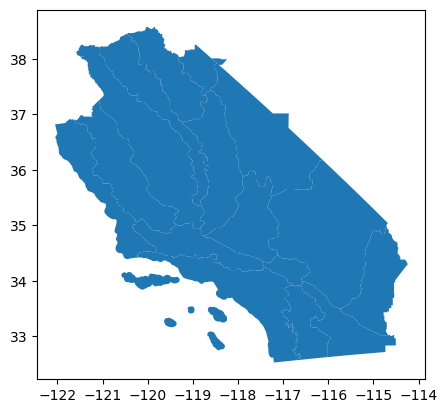

In [86]:
psabnd.plot()

<AxesSubplot:>

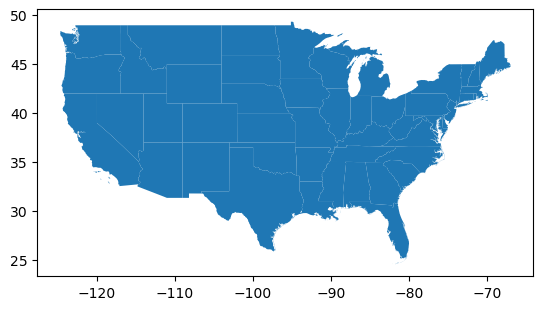

In [87]:
bnd.plot()

#### Define some chunks

In [88]:
mychunk = {'lat':100,'lon':100,'time': -1}

#### Open the example data file

In [89]:
df = xr.open_mfdataset('./Data/rtma-2022-09-1*T00%3A00%3A00Z.nc',chunks=mychunk,parallel=True)
df['jday'] = df.time.dt.dayofyear
df['hour'] = df.time.dt.hour
df['day'] = df.time.dt.day
df['month'] = df.time.dt.month
df['year'] = df.time.dt.year
df.rio.write_crs("epsg:4326", inplace=True)
df = df.chunk(mychunk)

In [90]:
df

,Array,Chunk
Bytes,1.34 GiB,3.66 MiB
Shape,"(96, 1597, 2345)","(96, 100, 100)"
Count,3460 Tasks,384 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.34 GiB,3.66 MiB
Shape,"(96, 1597, 2345)","(96, 100, 100)"
Count,3460 Tasks,384 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Create the function that is called by apply_ufunc

In [91]:
def calc_nfdrsv4_fm1_fm10_gufunc(t, r, pr, sr, w, jd,m,yr,d,hr,lat):
    # Output Vectors to save fuel moisture and indices    
    
    outfm1 = []
    outfm10 = []
    temp = (np.array(t) - 273.15)  # Convert K to C
    
    temp = temp.astype('float').ravel()
    
    rh = np.array(r) / 100.0 # Nelson requires RH in fractions
    rh = rh.astype('float').ravel()
    prcp = np.array(pr)  / 10 # Convert mm to cm
    prcp = prcp.astype('float').ravel()
    ws = np.array(w) * 2.23694 # Convert m/s to mph (Not really needed for Nelson yet)
    ws = ws.astype('float').ravel()
    srad = np.array(sr).astype('float').ravel()

    jd = np.array(jd).astype('int').ravel()
    day = np.array(d).astype('int').ravel()
    mon = np.array(m).astype('int').ravel()
    yr = np.array(yr).astype('int').ravel()
    hr = np.array(hr).astype('int').ravel()
    
    i = 0
    bp = 0.0218 # Atm. Pressure 
    AssumeHourlyPrecip = True
    with nfdrs.NFDRS4(float(lat),"Y",1,float(40),True,True,False) as fdr:
        for val in temp:
            if(srad[i] > 1400):
                srad[i] = 0
            #print(temp[i],rh[i],prcp[i],srad[i],ws[i])
            fdr.OneHourFM.update(int(yr[i]),int(mon[i]),int(day[i]),int(hr[i]),0,0,temp[i],rh[i],prcp[i],srad[i],bp,AssumeHourlyPrecip)
            fdr.TenHourFM.update(int(yr[i]),int(mon[i]),int(day[i]),int(hr[i]),0,0,temp[i],rh[i],prcp[i],srad[i],bp,AssumeHourlyPrecip)
            outfm1.append(fdr.OneHourFM.medianRadialMoisture())
            outfm10.append(fdr.TenHourFM.medianRadialMoisture())
            
            i = i + 1

        return np.array(outfm100),np.array(outfm1000)

In [92]:
def calc_nfdrsv4_fm100_fm1000_gufunc(t, r, pr, sr, w, jd,m,yr,d,hr,lat):
    # Output Vectors to save fuel moisture and indices    
    
    outfm100 = []
    outfm1000 = []
    temp = (np.array(t) - 273.15)  # Convert K to C
    
    temp = temp.astype('float').ravel()
    
    rh = np.array(r) / 100.0 # Nelson requires RH in fractions
    rh = rh.astype('float').ravel()
    prcp = np.array(pr)  / 10 # Convert mm to cm
    prcp = prcp.astype('float').ravel()
    ws = np.array(w) * 2.23694 # Convert m/s to mph (Not really needed for Nelson yet)
    ws = ws.astype('float').ravel()
    srad = np.array(sr).astype('float').ravel()

    jd = np.array(jd).astype('int').ravel()
    day = np.array(d).astype('int').ravel()
    mon = np.array(m).astype('int').ravel()
    yr = np.array(yr).astype('int').ravel()
    hr = np.array(hr).astype('int').ravel()
    
    i = 0
    bp = 0.0218 # Atm. Pressure 
    AssumeHourlyPrecip = True
    with nfdrs.NFDRS4(float(lat),"Y",1,float(40),True,True,False) as fdr:
        for val in temp:
            if(srad[i] > 1400):
                srad[i] = 1400
            if(rh[i] > .9999):
                rh[i] = 0.9999
            #print(temp[i],rh[i],prcp[i],srad[i],ws[i])
            fdr.HundredHourFM.update(int(yr[i]),int(mon[i]),int(day[i]),int(hr[i]),0,0,temp[i],rh[i],srad[i],prcp[i],bp,AssumeHourlyPrecip)
            
            fdr.ThousandHourFM.update(int(yr[i]),int(mon[i]),int(day[i]),int(hr[i]),0,0,temp[i],rh[i],srad[i],prcp[i],bp,AssumeHourlyPrecip)
            outfm100.append(fdr.HundredHourFM.medianRadialMoisture())
            #print(fdr.HundredHourFM.medianRadialMoisture())
            outfm1000.append(fdr.ThousandHourFM.medianRadialMoisture())
            
            i = i + 1

        return np.array(outfm100),np.array(outfm1000)

In [93]:
#### Map the function to the DataFrame using apply_ufunc

In [94]:
# Wrapper function to call the NFDRSV4 ufunc and remap the outputs into Xarray
def calc_nfdrsv4_fm100_fm1000(df):

    mc100,mc1000 = xr.apply_ufunc(
        calc_nfdrsv4_fm100_fm1000_gufunc,
        df.Temperature,df.Relative_humidity,df.Total_precipitation,df.Solar_radiation,
        df.Wind_speed, df.jday,df.month,df.year,df.day,df.hour,df.latitude,
        dask="parallelized",
        input_core_dims=[["time"],["time"],["time"],["time"],["time"],["time"],["time"],["time"],["time"],["time"],[]], 
        output_core_dims=[["time"],["time"]],
        vectorize=True, 
        output_dtypes=[df.Temperature.dtype,df.Temperature.dtype]
    )
    ds_out = mc100.to_dataset(name = 'fm100')
    ds_out["fm1000"] = mc1000
    return ds_out

In [95]:
if diagnostics:
    #temp = temp.rename({'lat':'latitude','lon':'longitude'})
    df.rio.write_crs("epsg:4326", inplace=True)
    df = df.rio.clip(bnd.geometry.values, bnd.crs)
    f,ax = plt.subplots()
    df.Temperature.mean('time').plot(ax=ax,cmap='RdYlBu_r')
    bnd.plot(facecolor='none',ax=ax)

In [99]:
df2_sl = df.rio.clip(psabnd.geometry.values, bnd.crs)

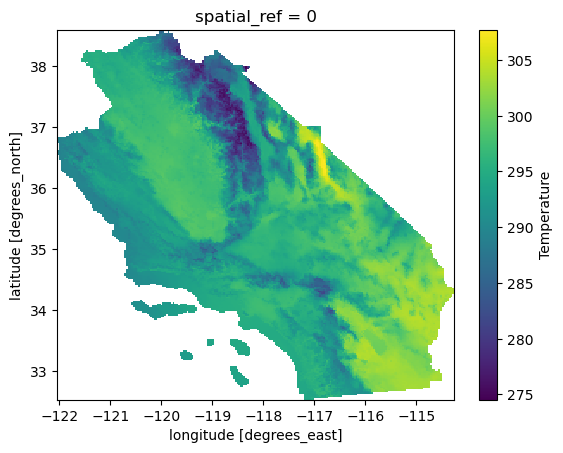

In [100]:
df2_sl.Temperature.mean('time').plot()

In [101]:
if diagnostics:
    
    # Missoula, MT
    lat = 46.8701049
    lon = -113.995267
    # Create a 2 deg by 2 deg box around Missoula and extract a slice of data
    xlim=(46,46.01)
    ylim=(-113.99,-113.97)
    spattest = True
    if spattest:
        latrange = slice(38,47)
        lonrange = slice(-122,-113)
        df2_sl = df.sel(lat=latrange,lon=lonrange)

    else:
        df2_sl = df.sel(lat=lat,lon=lon,method='nearest')


In [102]:
if diagnostics:
    hr = 0
    f,ax = plt.subplots(2,3,figsize=(12,8))
    df2_sl.Total_precipitation.plot(ax=ax[0][0])
    df2_sl.Temperature.plot(ax=ax[0][1])
    df2_sl.Relative_humidity.plot(ax=ax[0][2])
    df2_sl.Solar_radiation.plot(ax=ax[1][0])
    #t.fm100.plot(ax=ax[1][1])
    #t.fm1000.plot(ax=ax[1][1])
    plt.tight_layout()


In [103]:
df2_sl = df2_sl.chunk(mychunk)
df2_sl = df2_sl.rename({'lat':'latitude','lon':'longitude'})

df2_sl['jday'] = df2_sl.time.dt.dayofyear
df2_sl['hour'] = df2_sl.time.dt.hour
df2_sl['day'] = df2_sl.time.dt.day
df2_sl['month'] = df2_sl.time.dt.month
df2_sl['year'] = df2_sl.time.dt.year


In [104]:
%%time
with ProgressBar():
    t = calc_nfdrsv4_fm100_fm1000(df2_sl).compute()
t = t.transpose("time", "latitude","longitude")

Wall time: 1min


In [105]:
#df2_sl.rio.write_crs("epsg:4326",inplace=True) # Assign CRS to the Xarray
#clipped = df2_sl.rio.clip(bnd.geometry.apply(mapping), bnd.crs)  #Clip and mask Xarray
#clipped.Temperature[37].plot()
#t.fm100[0].plot(xlim=(46,46.01),ylim=(-113.99,-113.97))

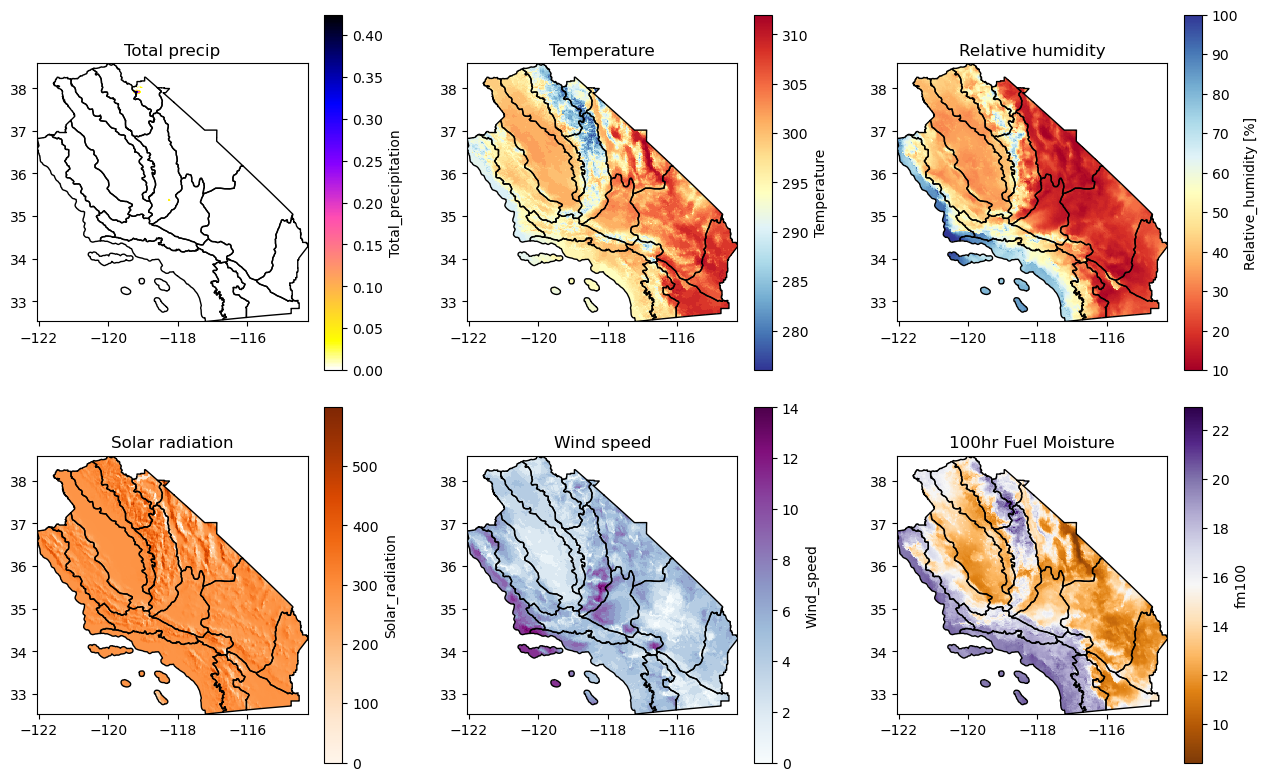

In [106]:
hr = 95

f,ax = plt.subplots(2,3,figsize=(13,8))
df2_sl.Total_precipitation[hr].plot(ax=ax[0][0],cmap="gnuplot2_r")
ax[0][0].set_title("Total precip")
psabnd.plot(facecolor='none',edgecolor='black',ax=ax[0][0])
df2_sl.Temperature[hr].plot(ax=ax[0][1],cmap='RdYlBu_r')
ax[0][1].set_title("Temperature")
psabnd.plot(facecolor='none',edgecolor='black',ax=ax[0][1])
df2_sl.Relative_humidity[hr].plot(ax=ax[0][2],cmap='RdYlBu')
ax[0][2].set_title("Relative humidity")
psabnd.plot(facecolor='none',edgecolor='black',ax=ax[0][2])
df2_sl.Solar_radiation[hr].plot(ax=ax[1][0],cmap='Oranges')
ax[1][0].set_title("Solar radiation")
psabnd.plot(facecolor='none',edgecolor='black',ax=ax[1][0])
df2_sl.Wind_speed[hr].plot(ax=ax[1][1],cmap='BuPu')
ax[1][1].set_title("Wind speed")
psabnd.plot(facecolor='none',edgecolor='black',ax=ax[1][1])
fm100grid = t.fm100[hr] * 100
fm100grid.plot(ax=ax[1][2],cmap='PuOr')
ax[1][2].set_title("100hr Fuel Moisture")
psabnd.plot(facecolor='none',edgecolor='black',ax=ax[1][2])
plt.tight_layout()

for x in range(0,2):
    for y in range(0,3):
        ax[x][y].set_xlabel('')
        ax[x][y].set_ylabel('')

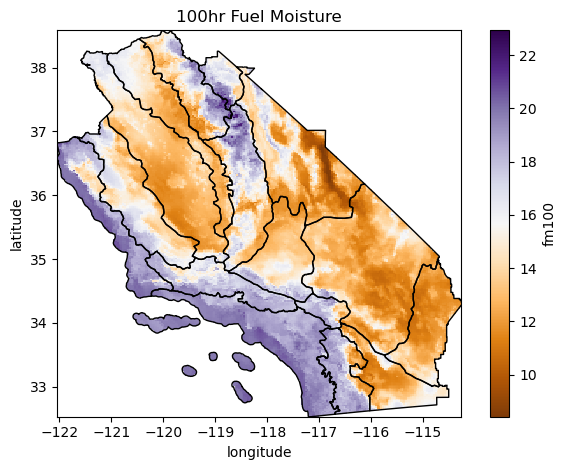

In [107]:
f,ax = plt.subplots()
fm100grid = t.fm100[hr] * 100
fm100grid.plot(ax=ax,cmap='PuOr')
ax.set_title("100hr Fuel Moisture")
psabnd.plot(facecolor='none',edgecolor='black',ax=ax)
plt.tight_layout()

In [ ]:
img.rio.write_crs("epsg:4326",inplace=True) # Assign CRS to the Xarray
clipped = img.rio.clip(bnd.geometry.apply(mapping), bnd.crs)  #Clip and mask Xarray

In [ ]:
clipped

In [ ]:
df2_sl.Temperature[12].plot(cmap='RdYlBu_r')

In [ ]:
%%time
zarrfo = '/mnt/nvmSSD/data/rtma/rtma_fm_hourly.zarr'
df2_sl = df.rename({'lat':'latitude','lon':'longitude'})
df2_sl = df2_sl.chunk({'latitude':500,'longitude':500,'time': -1})
t = df2_sl.map_blocks(calc_nfdrsv4_fm100_fm1000).squeeze().to_zarr(zarrfo,mode='w')

In [ ]:
t = t.transpose("time", "latitude", "longitude")

In [ ]:
temp

In [ ]:
temp.fm1000.mean('time').plot()

In [ ]:
clipped.fm1000.median('time').plot(cmap='RdYlBu')